In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/11.11 technology/project_single_image_per_class"
!ls data

In [ ]:
import os
import cv2
import math
import tqdm
import pickle
import numpy as np
from PIL import Image
from random import choice
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers, Model, Sequential
from tensorflow.keras.layers import BatchNormalization, Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(0)
np.random.seed(0)

### Reading TFrecord

In [ ]:
# function to parse single tfrecord example
def parse_tfrecord(tfrecord, normalize):
    features = {'image/source_id': tf.io.FixedLenFeature([], tf.int64),
                'image/encoded': tf.io.FixedLenFeature([], tf.string)}
    data = tf.io.parse_single_example(tfrecord, features)
    x_train = tf.image.decode_jpeg(data['image/encoded'], channels=3)
    y_train = tf.one_hot(data['image/source_id'], 8072)
    x_train = _transform_images()(x_train, normalize)
    return (x_train, y_train)


# function to do some data augmentation
def _transform_images():
    def transform_images(x_train, normalize):
        x_train = tf.image.resize(x_train, (160, 160))
        # x_train = tf.image.random_crop(x_train, (160, 160, 3))
        x_train = tf.image.convert_image_dtype(x_train, dtype=tf.float32, saturate=False)
        x_train = tf.image.random_flip_left_right(x_train)
        x_train = tf.image.random_saturation(x_train, 0.6, 1.4)
        x_train = tf.image.random_brightness(x_train, 0.4)
        if normalize:
            mean = tf.math.reduce_mean(x_train)
            std = tf.math.reduce_std(x_train)
            x_train = tf.math.subtract(x_train, mean)
            x_train = tf.math.divide(x_train, std)
        return x_train

    return transform_images


# reading tfrecord
def load_tfrecord_dataset(tfrecord_name, batch_size, repeat=False, normalize=True, shuffle=False, buffer_size=100000):
    """load dataset from tfrecord"""

    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    # raw_dataset = raw_dataset.repeat()

    if shuffle:
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)

    dataset = raw_dataset.map(lambda x: parse_tfrecord(x, normalize), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    if repeat:
        dataset = dataset.repeat()

    return dataset

total number of samples: 107242
<PrefetchDataset shapes: ((None, 160, 160, 3), (None, 8072)), types: (tf.float32, tf.float32)>
(101, 160, 160, 3) (101,)


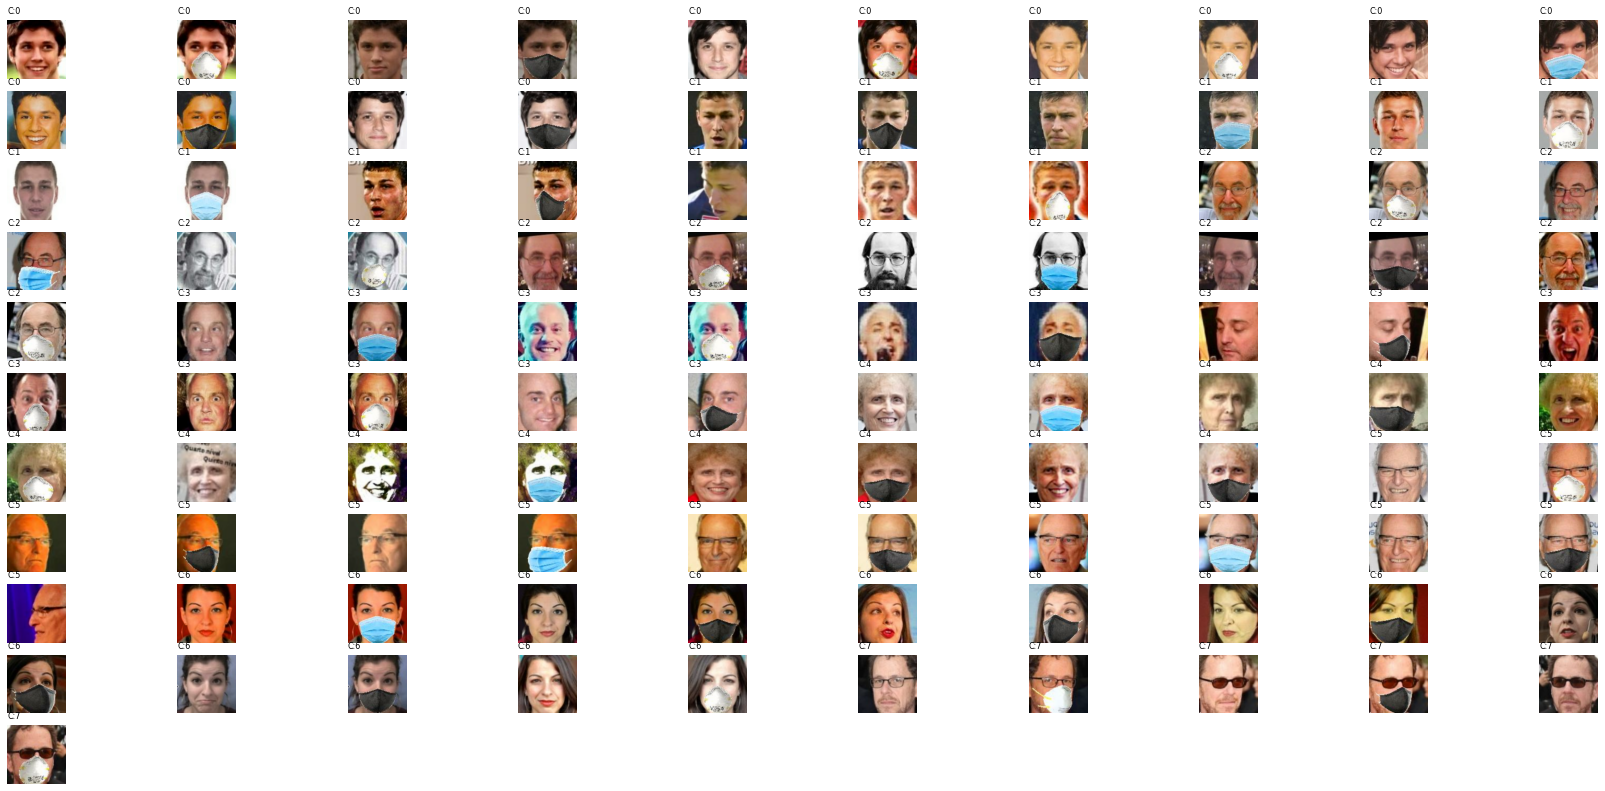

In [ ]:
tfrecord_name = "./data/msm1_train_7i_pm_r5_l(8072).tfrecord"
dataset_len = sum(1 for _ in tf.data.TFRecordDataset(tfrecord_name))
print("total number of samples:", dataset_len)

dataset = load_tfrecord_dataset(tfrecord_name, 1, normalize=False, shuffle=False)

print(dataset)

count = 0

images = list()
labels = list()
labels_index = list()

for record in dataset:

    (a, b) = (record)

    # print(a.shape, b.shape)

    images.append(a[0])
    labels.append(np.argmax(b[0]))

    if count >=100:
        break
    count += 1

images = np.array(images, dtype=np.uint8)
labels = np.array(labels, dtype=np.uint8)

print(images.shape, labels.shape)

plt.figure(figsize=(30,700))
for i in range(len(images)):
    plt.subplot(540, 10, i+1)
    plt.axis('off')
    plt.title("C:" + str(labels[i]), loc="left", fontsize=8)
    plt.imshow(images[i])
plt.show()

# Get Data

In [ ]:
train_tfrecord_name = "./data/msm1_train_7i_pm_r5_l(8072).tfrecord"
train_batch_size = 128

train_dataset_len = sum(1 for _ in tf.data.TFRecordDataset(train_tfrecord_name))
print("total number of samples:", train_dataset_len)

train_dataset = load_tfrecord_dataset(train_tfrecord_name, train_batch_size, shuffle=True)

print(train_dataset)

total number of samples: 107242
<PrefetchDataset shapes: ((None, 160, 160, 3), (None, 8072)), types: (tf.float32, tf.float32)>


In [ ]:
test_tfrecord_name = "./data/msm1_test_7i_pm_r5_l(8072).tfrecord"

test_dataset_len = sum(1 for _ in tf.data.TFRecordDataset(test_tfrecord_name))
print("total number of samples:", test_dataset_len)

test_dataset = load_tfrecord_dataset(test_tfrecord_name, 128, shuffle=False)

print(test_dataset)

total number of samples: 457182
<PrefetchDataset shapes: ((None, 160, 160, 3), (None, 8072)), types: (tf.float32, tf.float32)>


In [ ]:
val_tfrecord_name = "./data/msm1_val_7i_pm_r5_l(8072).tfrecord"

val_dataset_len = sum(1 for _ in tf.data.TFRecordDataset(val_tfrecord_name))
print("total number of samples:", val_dataset_len)

val_dataset = load_tfrecord_dataset(val_tfrecord_name, train_batch_size, shuffle=True)

print(val_dataset)

total number of samples: 45958
<PrefetchDataset shapes: ((None, 160, 160, 3), (None, 8072)), types: (tf.float32, tf.float32)>


# Training

In [ ]:
w_decay = 1e-4
emb_shape = 10000
num_classes = 8072

# using facenet as the backbone model
model_face = load_model('facenet_keras.h5')

# adding custom layers
last = model_face.output
x = Dense(emb_shape, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(w_decay))(last)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(num_classes, activation = "softmax", kernel_regularizer=regularizers.l2(w_decay), name="last_layer")(x)

model = Model(inputs=model_face.input, outputs=x, name="model_1")

In [ ]:
lr = 0.005
min_lr = 0.0005
momentum = 0.5
total_epochs = 50   
steps_per_epoch = train_dataset_len // train_batch_size

def scheduler(epoch, lr):
    print(lr)
    if epoch < 10:
        return lr
    else:
        return min(lr * tf.math.exp(-0.1), min_lr)

# callbacks 
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

history = model.fit(train_dataset.repeat(), epochs=total_epochs, verbose=1, steps_per_epoch=steps_per_epoch, callbacks=[callback_es, callback_lr], validation_data=val_dataset)

Epoch 1/50
0.004999999888241291
837/837 [==============================] - 584s 646ms/step - loss: 10.5035 - accuracy: 0.0679 - val_loss: 7.7857 - val_accuracy: 0.4219
Epoch 2/50
0.004999999888241291
837/837 [==============================] - 522s 620ms/step - loss: 6.3285 - accuracy: 0.5576 - val_loss: 5.2266 - val_accuracy: 0.7485
Epoch 3/50
0.004999999888241291
837/837 [==============================] - 520s 622ms/step - loss: 4.4348 - accuracy: 0.8284 - val_loss: 4.3209 - val_accuracy: 0.8309
Epoch 4/50
0.004999999888241291
837/837 [==============================] - 520s 622ms/step - loss: 3.7394 - accuracy: 0.9088 - val_loss: 3.9614 - val_accuracy: 0.8574
Epoch 5/50
0.004999999888241291
837/837 [==============================] - 548s 655ms/step - loss: 3.4346 - accuracy: 0.9434 - val_loss: 3.7899 - val_accuracy: 0.8689
Epoch 6/50
0.004999999888241291
837/837 [==============================] - 547s 653ms/step - loss: 3.2656 - accuracy: 0.9617 - val_loss: 3.6863 - val_accuracy: 0.87

In [ ]:
model.save("model_(msm1).h5")

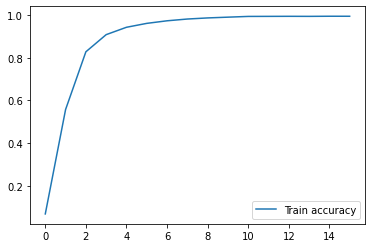

In [ ]:
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.legend(loc="best")
plt.show()

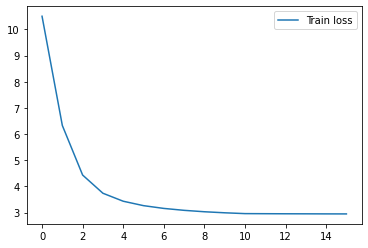

In [ ]:
plt.plot(history.history["loss"], label="Train loss")
plt.legend(loc="best")
plt.show()

# Testing


In [ ]:
model = tf.keras.models.load_model('model_(msm1).h5')

In [ ]:
# testing
model.evaluate(test_dataset) 

3572/3572 [==============================] - 555s 155ms/step - loss: 3.3129 - accuracy: 0.9226


[3.3128719329833984, 0.9226216077804565]

In [ ]:
test_tfrecord_name_ = "./data/msm1_test_7i_pm_r5_l(8072).tfrecord"

test_dataset_ = load_tfrecord_dataset(test_tfrecord_name_, 1, shuffle=False)

# get wrong predict image
images = list()
true_labels = list()
predicted_labels = list()
count = 0

for record in test_dataset_:

    (a, b) = (record)
    count += 1

    # print(a.shape, b.shape)
    prediction = model.predict(a)
    predicted_label = np.argmax(prediction, axis=1)
    true_label = np.argmax(b, axis=1)
    # print(predicted_label, true_label)

    # for i in range(len(predicted_label)):
    #     if predicted_label[i] != true_label[i]:
    #         images.append(a[i]) 
    #         true_labels.append(true_label[i])
    #         predicted_labels.append(predicted_label[i])
    print(count)

    if predicted_label[0] != true_label[0]:
        images.append(a[0])
        true_labels.append(true_label[0])
        predicted_labels.append(predicted_label[0])

print(len(images), len(true_labels), len(predicted_labels))

In [ ]:
print(len(images), len(true_labels), len(predicted_labels))

In [ ]:
plt.figure(figsize=(25, 800))

for i in range(len(images[10000:])):
    plt.subplot(500, 10, i+1)
    plt.axis('off')
    plt.title("T:" + str(true_labels[i + 10000]), loc="left", fontsize=8)
    plt.title("P:" + str(predicted_labels[i + 10000]), loc="right", fontsize=8)

    img = images[i + 10000].numpy()
    minFrom= img.min()
    maxFrom= img.max()
    minTo = 0
    maxTo = 1
    img = minTo + (maxTo - minTo) * ((img - minFrom) / (maxFrom - minFrom))
    plt.imshow(img)

In [ ]:
def show_batch_predictions(image_batch, label_batch):
    plt.figure(figsize=(25, 800))
    for i in range(len(image_batch)):
        ax = plt.subplot(500, 10, i + 1)
        plt.imshow(image_batch[i])
        img_array = tf.expand_dims(image_batch[i], axis=0)
        plt.title("Predict:" + str(np.argmax(model.predict(img_array)[0])), loc="left", fontsize=8)
        plt.title("True:" + str(np.argmax(label_batch[i])), loc="right", fontsize=8)
        plt.axis("off")
    plt.show()
show_batch_predictions(X_test[0:1000], y_test[0:1000])